<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/SciKitLearn_06_ProjSix_Supervised_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libs

In [328]:
!pip install -q import_ipynb openpyxl

In [329]:
# utils
import os, sys, time, warnings
import logging
import import_ipynb
import scipy.io
import pandas as pd
import numpy as np
from scipy import stats

# colab
from google.colab import drive
# sklearn
import sklearn
from sklearn import preprocessing, metrics, linear_model, svm
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# vis
import matplotlib.pyplot as plt
import seaborn as sns

In [330]:
print(sys.version)
print("sklearn: ", sklearn.__version__)

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
sklearn:  1.5.2


## Setting

In [331]:
warnings.filterwarnings('ignore')

In [332]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [333]:
# working directory
working_dir = '/content/drive/MyDrive/Jupyter Notebooks/'
os.chdir(working_dir)

In [334]:
# load MachineLearningUtils
from MachineLearningUtils import *

In [335]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

## Understand Dataset

In [336]:
path = 'Inputs/'

In [337]:
mmc3 = scipy.io.loadmat(path +'mmc3.mat')
mmc3.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Xcal', 'Xtest', 'ycal', 'ytest', 'xaxis', 'SpectraTotal'])

In [338]:
X_train = mmc3['Xcal']
X_test = mmc3['Xtest']
y_train =mmc3['ycal']
y_test=mmc3['ytest']

In [339]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((203, 1154), (110, 1154), (203, 1), (110, 1))

In [340]:
spectra = mmc3['SpectraTotal']

In [341]:
wavenumber =mmc3['xaxis']
wavenumber = np.flip(wavenumber)

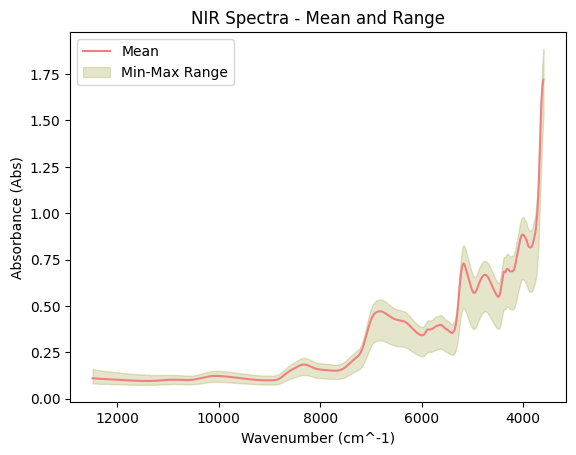

In [342]:
plt.plot(wavenumber.flatten(), np.mean(spectra, axis=0), color='lightcoral', label='Mean')
plt.fill_between(wavenumber.flatten(), np.min(spectra, axis=0), np.max(spectra, axis=0), color='olive', alpha=0.2, label='Min-Max Range')

plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance (Abs)')
plt.title('NIR Spectra - Mean and Range')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [343]:
iodine = pd.read_excel(path + 'mmc2.xlsx')
iodine.head()

,Iodine,NIR-model
0,0.00,1.554000
1,2.00,3.395400
2,2.00,3.395400
3,2.70,4.039890
4,2.75,4.085925


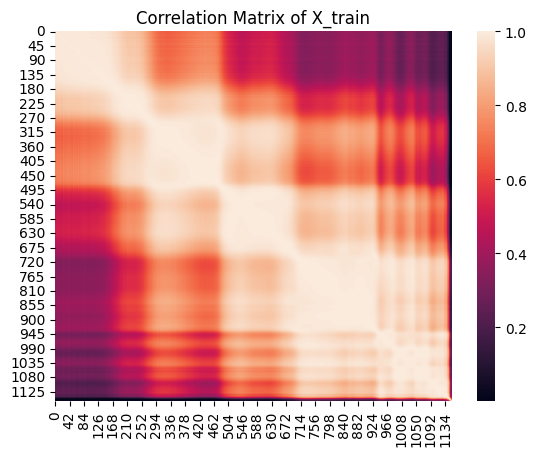

In [344]:
sns.heatmap(np.corrcoef(X_train, rowvar=False)**2)
plt.title('Correlation Matrix of X_train')
plt.show()

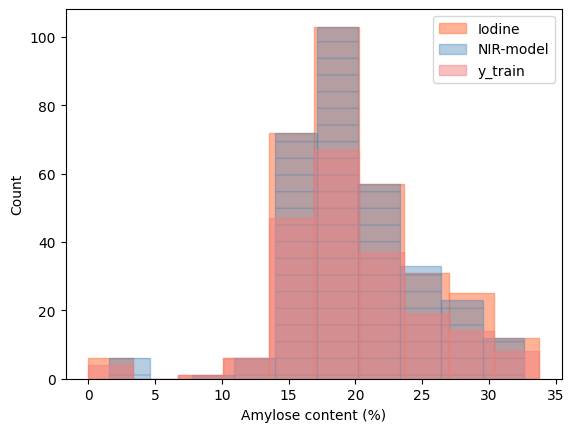

In [345]:
plt.hist(iodine['Iodine'], alpha=0.6, label='Iodine', color="coral", edgecolor='coral')
plt.hist(iodine['NIR-model'], alpha=0.4, label='NIR-model', color="steelblue", edgecolor='steelblue', hatch='-')
plt.hist(y_train, alpha=0.5, label='y_train', color='lightcoral', edgecolor='lightcoral')
plt.xlabel('Amylose content (%)')
plt.ylabel('Count')
plt.legend()
plt.show()

In [346]:
def msc(x): # multiplicative scatter correction
    x = (x - np.mean(x, axis=1)[:, np.newaxis])
    msc = np.zeros_like(x)
    for i in range(x.shape[0]):
        _ = np.mean(x[i:i + 10], axis=0)
        fit = np.polyfit(_, x[i, :], 1)
        msc[i, :] = (x[i, :] - fit[1]) / fit[0]
    return msc

In [347]:
X_msc = msc(X_train)

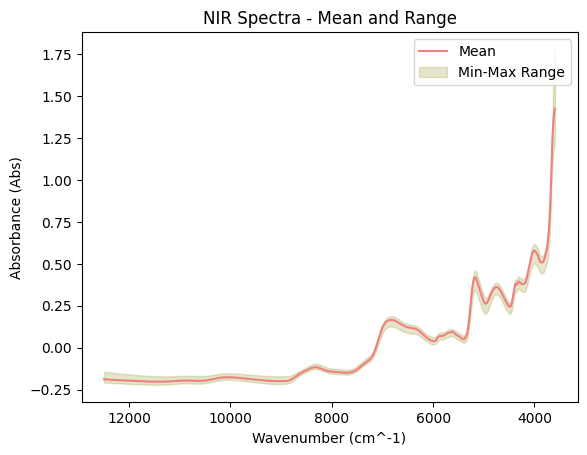

In [348]:
plt.plot(wavenumber.flatten(), np.mean(X_msc, axis=0), color='lightcoral', label='Mean')
plt.fill_between(wavenumber.flatten(), np.min(X_msc, axis=0), np.max(X_msc, axis=0), color='olive', alpha=0.2, label='Min-Max Range')
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance (Abs)')
plt.title('NIR Spectra - Mean and Range')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

## Model

In [349]:
def scale_train_test(train_data, test_data, scaler):
    scaled_train_data = scaler.fit_transform(train_data)
    scaled_test_data = scaler.transform(test_data)
    return scaled_train_data, scaled_test_data

def scaler(x_train, x_test, y_train, y_test):
    x_scaler = preprocessing.StandardScaler()
    y_scaler = preprocessing.StandardScaler()
    x_train_scaled, x_test_scaled = scale_train_test(x_train, x_test, x_scaler)
    y_train_scaled, y_test_scaled = scale_train_test(y_train, y_test, y_scaler)

    return x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled

In [350]:
def compute_derivatives(x_train, x_test, dv=1):
    """
    Compute the first or second derivatives of x_train and x_test.

    Parameters:
    x_train : numpy.ndarray
        Training data where derivatives will be computed row-wise.
    x_test : numpy.ndarray
        Test data where derivatives will be computed row-wise.
    dv : int, optional (default=1)
        Degree of derivative to compute. 1 for first derivative, 2 for second.

    Returns:
    x_train_deriv : numpy.ndarray
        Transformed training data with computed derivatives.
    x_test_deriv : numpy.ndarray
        Transformed test data with computed derivatives.
    """

    def compute_gradient(data, dv):
        """
        Helper function to compute the first or second derivative for a dataset.

        Parameters:
        data : numpy.ndarray
            Dataset to compute derivatives for.
        dv : int
            Degree of derivative to compute (1 or 2).

        Returns:
        numpy.ndarray
            Dataset after applying the derivative transformation.
        """
        # compute the first derivative row-wise
        derivatives = np.apply_along_axis(np.gradient, 1, data)

        # if dv == 2, compute second derivative on the first derivative result
        if dv == 2:
            derivatives = np.apply_along_axis(np.gradient, 1, derivatives)

        return derivatives

    x_train_deriv = compute_gradient(x_train, dv)
    x_test_deriv = compute_gradient(x_test, dv)

    return x_train_deriv, x_test_deriv

In [351]:
def model_fit(x_train, x_test, y_train, y_test, n_components=2):
    """
    Fits a Partial Least Squares (PLS) Regression model to the training data and evaluates it on the test data.

    Parameters:
    x_train : numpy.ndarray
        Training feature matrix.
    x_test : numpy.ndarray
        Test feature matrix.
    y_train : numpy.ndarray
        Training target vector or matrix.
    y_test : numpy.ndarray
        Test target vector or matrix.
    n_components : int, optional (default=2)
        Number of PLS components to use.

    Returns:
    mse : float
        Mean squared error of the model on the test data.
    r2 : float
        R-squared score of the model on the test data.
    """
    try:
        pls = PLSRegression(n_components=n_components)
        pls.fit(x_train, y_train)
        y_pred = pls.predict(x_test)

        # calculate metrics: MSE and R-squared
        mse = metrics.mean_squared_error(y_test, y_pred)
        r2 = metrics.r2_score(y_test, y_pred)

        return mse, r2

    except Exception as e:
        # log the exception with a meaningful message
        logging.error(f"An error occurred during model fitting: {str(e)}")
        return None, None


In [352]:
X_train = mmc3['Xcal']
X_test = mmc3['Xtest']
y_train =mmc3['ycal']
y_test=mmc3['ytest']

In [353]:
cutoff_value = 0.20
X_train = np.where(X_train <= cutoff_value, 0, X_train)
X_test = np.where(X_test <= cutoff_value, 0, X_test)
X_train = msc(X_train)
X_test = msc(X_test)
X_train, X_test, y_train, y_test = scaler(X_train, X_test, y_train, y_test)

In [354]:
best_r2 = float('-inf')
optimal_components = None
best_mse = None

for n_components in range(2, 100):
    try:
        mse, r2 = model_fit(X_train, X_test, y_train, y_test, n_components)
        if r2 > best_r2:
            best_r2 = r2
            optimal_components = n_components
            best_mse = mse
    except Exception as e:
        logging.warning(f"Model fitting failed for n_components={n_components}: {str(e)}")
        continue

print(f"Optimal number of components: {optimal_components}")
print(f"Best R-squared: {best_r2:.4f}")
print(f"Corresponding MSE: {best_mse:.4f}")

Optimal number of components: 59
Best R-squared: 0.7841
Corresponding MSE: 0.2101


In [355]:
pls_model = PLSRegression(n_components=n_components)
pls_model.fit(X_train, y_train)
y_pred = pls_model.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 0.6464


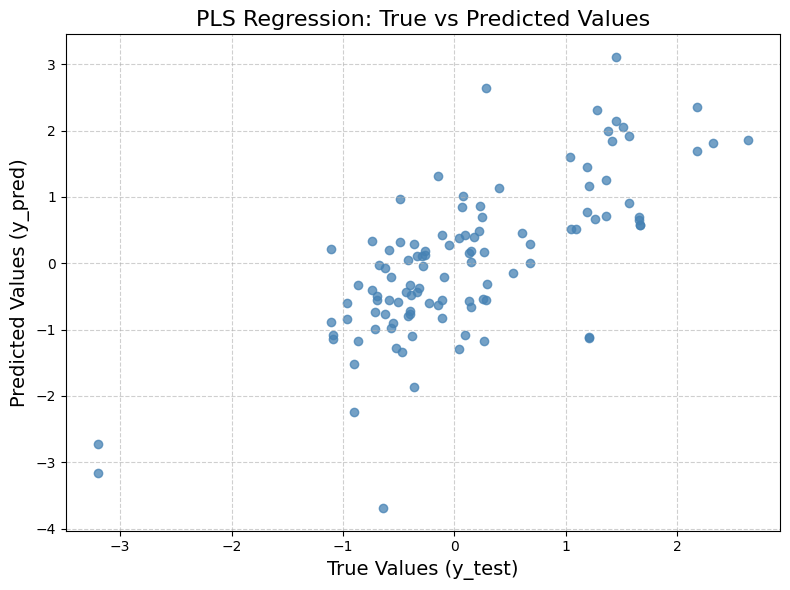

In [356]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='steelblue', alpha=0.75)
plt.xlabel('True Values (y_test)', fontsize=14)
plt.ylabel('Predicted Values (y_pred)', fontsize=14)
plt.title('PLS Regression: True vs Predicted Values', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()